# Credit Card Fraud

Credit card fraud is a problem that finance companies which offer consumers credit cards would like to eliminate. Since there are around 1 billion credit card transactions which take place every day, manually flagging and cancelling fraudulent transactions is entirely unfeasible. With machine learning, we can train a computer to distinguish fraudulent transactions from real ones using previous examples. This protects the company from liability and loss and also reduces operating costs.

The following dataset is from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The dataset contains transactions made with credit cards by European cardholders in September 2013. The data has gone through dimensionality reduction via PCA, which anonymizes the data and also makes it easier for a machine learning model to learn from. 

The only features which remain untransformed are the 'Time' and 'Amount' features. The 'Time' column contains the seconds elapsed between each transaction and the first transaction in the dataset. The 'Amount' feature is the transaction amount. Finally, the 'Class' feature is the target variable, with '1' being a fraudulent transaction and 0 otherwise.

The dataset author recommends: 
> Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns

CREDIT_CARD_FILENAME = 'creditcard.csv'
RANDOM_STATE = 3
    
def load_credit_card_data(file_path=CREDIT_CARD_FILENAME):
    csv_path = os.path.join('data', file_path)
    return pd.read_csv(csv_path)

credit_card = load_credit_card_data()

## Exploration

In [2]:
credit_card.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print('Frequencies')
print(credit_card.value_counts('Class'))

Frequencies
Class
0    284315
1       492
dtype: int64


We can see how unbalanced the class ratio is. Also, we can see above that each feature has been re-labeled as V1-V28.

Below is a simple visualization of the class imbalance.

array([[<AxesSubplot:title={'center':'Class'}>]], dtype=object)

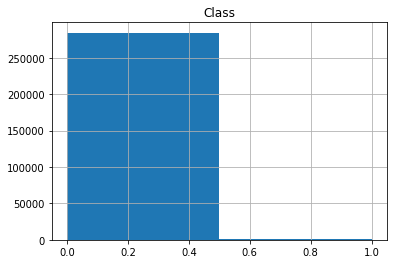

In [4]:
credit_card.hist('Class', bins=2)

We should check to see if there are correlations hidden in the data using a correlation matrix and then plot it with a heatmap using Seaborn.

<AxesSubplot:>

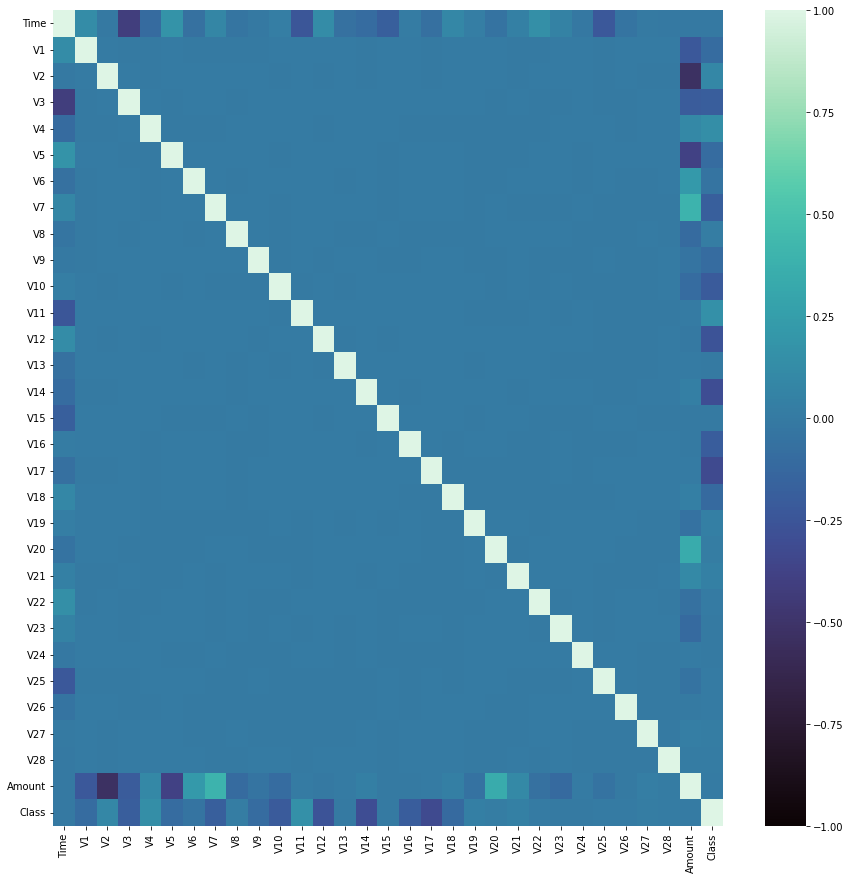

In [5]:
corr = credit_card.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, vmin=-1.0, cmap='mako')

The first thing that jumps out to me is that there is 0.0 correlation between the `V` features. I'm not sure if the PCA process affects the correlation between these features. 

There are correlations between the `V` features and `Time`, but that sounds like it's occuring due to chance. The `Time` feature does not scream 'important' to me since it is just an elapsed time since the first transaction in the dataset. I think a more descriptive feature would be something like elapsed time since the customer's last transaction. For example, multiple transactions within a very short period would likely indicate fraudulent activity.

The heat map shows that there are varying amounts of correlation between `Amount` and `V`. I'm not gleaning much information from this heat map.

Now let's quickly check if there are any missing values:

In [6]:
credit_card.isna().sum().sum()

0

A value of zero after converting to True/False and summing on both axes means there are zero missing values.

In [7]:
# pd.options.display.float_format = '{:.2f}'.format  # suppress scientific notation

credit_card.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Looking at the above table, I can tell that all features except time having a mean of zero and a standard deviation somewhere around unity. A standardized distribution would have a unit variance. Since I'm going to use Decision Trees and Random Forests as my classification model this isn't something I'm worried about. Further, the `Time` feature is not going to help us much, so I'm going to drop it. 

## Preprocessing

I'm going to use a `DecisionTreeClassifier` and a `RandomForestClassifier` on this dataset. These types of models do not require much data preparation. The PCA that has been done on the data will help us, but I do not need to, for example, standard the `Amount` column.

I thought about creating an ordinal feature for the `Amount` column, i.e. 'Low', 'Medium', and 'High' transaction amounts. However, this would require binning and while I can be sure that the minimum transaction amount would be zero, I can't be sure what the maximum is.

In [8]:
cc = credit_card.drop(['Time'], axis=1)

cc.sample(5, random_state=RANDOM_STATE)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
55131,1.236040,0.246604,0.173098,0.505621,-0.209898,-0.572866,-0.067674,0.001954,-0.104800,-0.094105,...,-0.265297,-0.832876,0.083357,-0.060474,0.208230,0.099839,-0.031663,0.015881,1.98,0
64433,1.106600,-0.983435,-0.435849,-0.965108,-0.195159,0.362881,-0.286150,-0.028419,-1.248617,0.678555,...,0.325425,0.557488,-0.397485,-1.078475,0.657093,-0.052477,-0.019239,0.015687,174.95,0
200319,2.053859,0.017620,-1.044302,0.398776,-0.017421,-1.103648,0.242713,-0.369792,0.378501,0.033398,...,-0.271011,-0.588222,0.333976,0.015987,-0.277432,0.197468,-0.060623,-0.058174,1.98,0
12004,-0.333837,1.250884,1.437889,0.263291,0.111567,-0.937753,0.611525,-0.152919,0.890815,-0.880124,...,-0.415962,-0.876026,-0.009245,0.268013,-0.183962,0.033665,0.219739,0.091659,0.89,0
202700,-1.013271,1.867706,0.738315,2.500517,1.369829,0.188423,1.257136,-0.109642,-1.499215,1.349855,...,-0.238084,-0.539922,0.054420,0.668912,-0.531066,-0.536876,-0.475286,-0.239140,4.94,0


The biggest problem with this dataset, as I mentioned, is the class imbalance. To fix this we can do one of either of two things. We can either oversample the fraudulent cases or undersample the non-fraudulent transactions. Either way will balance the classes, but oversampling will result in much more data to train on, albeit with many copies of the fraudulent data.

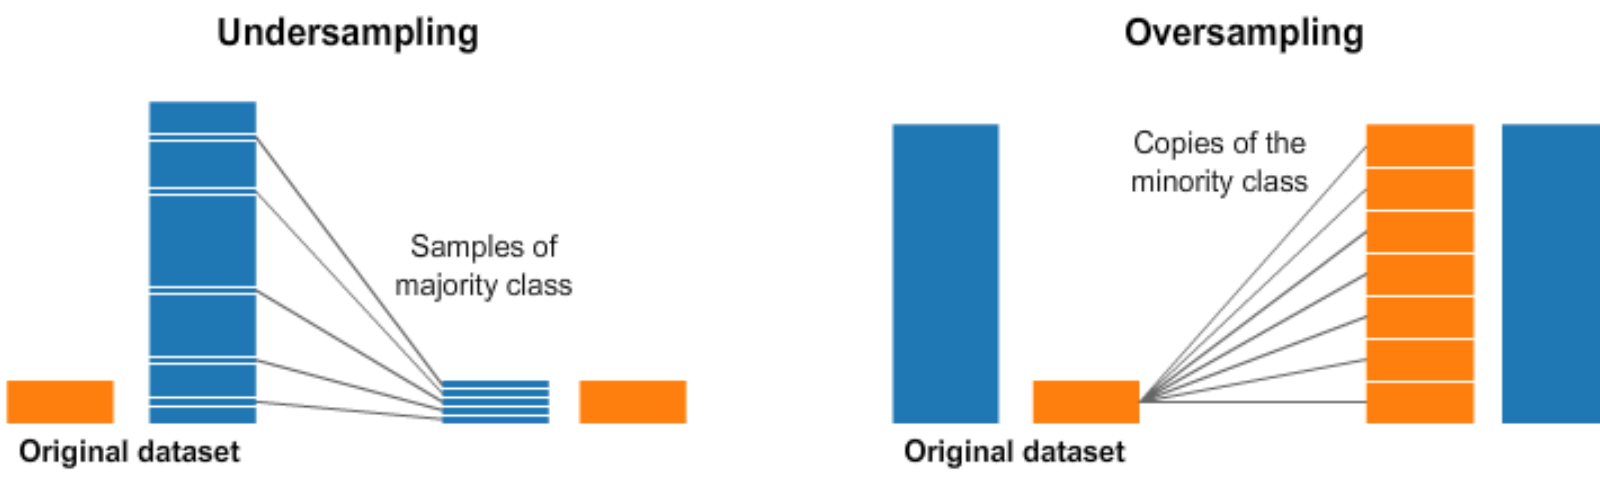

Over- and undersampling the data isn't too hard to implement. I'll do both and then compare the models' generalization performances on those datasets with the original dataset.

For undersampling, we are going to use all of the fraudulent transaction instances and then sample random instances from the non-fraudulent transaction instances:

In [9]:
# undersampling
min_class_len = np.min(cc['Class'].value_counts().values)

class_subsets = [cc.query('Class ==' + str(i)) for i in range(2)]

for i in range(2):
    # replace = False here since we are undersampling
    class_subsets[i] = class_subsets[i].sample(n=min_class_len, replace=False, random_state=RANDOM_STATE)

# concatenate the subsets on axis 0, sample method shuffles the data, then reset index 
undersampled_cc = pd.concat(class_subsets, axis=0).sample(frac=1.0).reset_index(drop=True)

print(undersampled_cc['Class'].value_counts())

1    492
0    492
Name: Class, dtype: int64


Now we can see that we have data that is balanced between both classes.

Similarly, we'll oversample the fraudulent transactions now:

In [10]:
# oversampling
max_class_len = np.max(cc['Class'].value_counts().values)

class_subsets = [cc.query('Class ==' + str(i)) for i in range(2)]

for i in range(2):
    # replace = True here since we are oversampling the fraudulent cases, otherwise we would run out of instances
    class_subsets[i] = class_subsets[i].sample(n=max_class_len, replace=True, random_state=RANDOM_STATE)

# concatenate the subsets on axis 0, sample method shuffles the data, then reset index 
oversampled_cc = pd.concat(class_subsets, axis=0).sample(frac=1.0).reset_index(drop=True)

print(oversampled_cc['Class'].value_counts())

0    284315
1    284315
Name: Class, dtype: int64


Now we have prepared three versions of the original dataset: `cc`, `undersampled_cc`, and `oversampled_cc`.

# Training

For training, I'll be comparing a decision tree and random forest classifier. I expect the random forest to perform better than the decision tree, since it is an amalgamation of the latter. Since we don't know anything about the features, it is not particularly important that we won't know which features are particularly influential to the target variable. Even if the model could tell us what features are important to determining whether a transaction is fraudulent or not, it wouldn't matter since we don't know what each feature represents.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

rf_clf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
dt_clf = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [12]:
# print(cc['Class'].value_counts())
# print(undersampled_cc['Class'].value_counts())
# print(oversampled_cc['Class'].value_counts())

# function to train
def train_model(data, model, model_str, data_str):
    data = data.copy()
    X, y = data.drop(['Class'], axis=1), data[['Class']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=RANDOM_STATE)
    
    m = model.fit(X_train, y_train.values.ravel())
    
    preds = model.predict(X_test)
    
    print(f'{model_str}, {data_str}:\n', classification_report(y_test, preds), confusion_matrix(y_test, preds))    

In [13]:
train_model(cc, dt_clf, 'Decision Tree', 'Imbalanced CC')
train_model(oversampled_cc, dt_clf, 'Decision Tree', 'Oversampled CC')
train_model(undersampled_cc, dt_clf, 'Decision Tree', 'Undersampled CC')

Decision Tree, Imbalanced CC:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85291
           1       0.76      0.73      0.74       152

    accuracy                           1.00     85443
   macro avg       0.88      0.86      0.87     85443
weighted avg       1.00      1.00      1.00     85443
 [[85256    35]
 [   41   111]]
Decision Tree, Oversampled CC:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85330
           1       1.00      1.00      1.00     85259

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589
 [[85302    28]
 [    0 85259]]
Decision Tree, Undersampled CC:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       148
           1       0.91      0.91      0.91       148

    accuracy            

Let's take a look at what's going on with the performances of the various decision trees above. First recall the definitions of *precision* and *recall*:

>precision: the ratio of true positives to the total number of positive predictions
>recall: the ratio of true positives to the number of instances correctly classified by the model

With the imbalanced dataset, we can see that we are probably overfitting with respect to the negative class. From the confusion matrix, we see that the precision and recall of 1.00 of the negative class as shown in the classification report is due to rounding. 

When we oversample, we get definitely get overfitting on the positive class. This is not surprising, since we have so many copies of the positive class due to oversampling the tiny class to equal the total number of negative instances. The model does slightly word 199365

In [14]:
# train_model(cc, rf_clf, 'Random Forest', 'Imbalanced CC')
# train_model(oversampled_cc, rf_clf, 'Random Forest', 'Oversampled CC')
# train_model(undersampled_cc, rf_clf, 'Random Forest', 'Undersampled CC')